- Title: Tosser
- Subtitle: Beating an Interview Question
- Date: 2018-10-14 15:05
- Category: Puzzle
- Tags: puzzle, gym, interview
- Author: Varun Nayyar




While chatting with Joe, a bloke I had met at a machine learning meet, the conversation invariably turned to how we hated interviewing and how interview candidates always throw out buzzwords and jump headfirst into problems. We then asked each other our favourite interview questions and jumped in headfirst without thinking.
In order to defend my behaviour, I argued that the question Joe had posed was far more subtle than what Joe had suggested and this is the result.


## The Game

The game was this: You can bet as much money as you want on the outcome of a coin toss. If it's heads, you win 3x what you bet (plus whatever you bet) while if it's tails, you lose whatever you've bet. A more concrete example, you bet 100 on the toss, if it's heads you win 300 so your total amount is now 400, while if it's tails, you're left with 0. This is obviously a positive game, betting $x$ has an expected return of $x$. (A normal toss game has an expected return of 0 in comparison)

Note I define return as winnings. So starting with 100 and leaving with 1000 is a return of 900. I define value as sum of winnings + initial investment. So starting with 100 and leaving with 1000 is a value of 1000.

The subtlety of this game is introduced in the fact that you only get a finite number of turns with this game. 

## The Subtlety

If this game had only 1 turn, you'd bet as much money as possible on the game. After all, who'd give you a 50% chance at a 300% return, or an expected return of 100% (albeit slightly risky). If this game had infinite number of turns, I would play with the minimum bet each time as my expected return is the minimum bet and the chance of going to 0 is very very rare. Note, this is also why when playing in a casino, you reduce the number of bets you make because each bet has a negative expected return. 

With a finite number of turns, the game changes. If I had 2 turns, betting all my money each time still seems sound since 25% of the time I'd end up 16x or 1500% return with a 25% probability - still appetizing. But nothing 75% of the time. For a game with 10 turns, I'd make a 1 million x return, but this is a 1 in 1024 chance of happening, everything else is 0. Note that my expected return is $(2^n-1)x$ using this strategy, but my median return is $-x$. As $n \rightarrow \infty$ my expected return also grows, but my chance of winning keeps decreasing. Now I don't play the lottery, and if a billionaire decides to match every dollar in the lottery with 3 of his own, I still wouldn't play the game (though I would pool money and buy as many lottery tickets as possible). So obviously, this strategy of betting everything on each toss is not something I'd want to do



## Constant Betting Strategy

The first time I posed this question to another, the first response I got was what was I optimizing for? It's clear that optimizing for expected value results in a bet everything each toss, but this is not a good strategy as the number of tosses increase as the chance of any payout diminishes. The next response was to bet half my stash each time so I'd never be out of the game, so I thought I'd look at various statistics for a constant $\lambda$

Let $\lambda \in [0,1]$ be the percentage of our current stash $x$ to bet on the toss. Value $V$ after one toss

\begin{align}
V|Heads =& (1-\lambda) x + 4 \lambda x\\
 =& (1 +3 \lambda)x \\
V|Tails =& (1-\lambda) x 
\end{align}

Hence $E(V) = (1+\lambda)x$ 

Looking at 2 tosses

\begin{align}
V|HH =& (1 -\lambda)(V|H) + 4\lambda (V|H) \\
 =& (1 +3 \lambda)(V|H) \\
 =& (1 +3 \lambda)^2x \\
V|HT =& (1 +3 \lambda)(V|T)\\
=& (1 +3 \lambda)(1-\lambda) x
\end{align}

and 

\begin{align}
V|TT =& (1 -\lambda)(V|T) \\
 =& (1 - \lambda)^2x \\
V|TH =& (1 +3 \lambda)(V|T)\\
=& (1 +3 \lambda)(1-\lambda) x
\end{align}

This should give us some intuition on the distribution. For a particular fixed strategy, i.e. constant $\lambda$, we now have a distribution given number of heads, $h$ and number of tails $t$

\begin{align}
V|H=h, T=t &= (1+3\lambda)^h (1-\lambda)^t x
\end{align}

For $\lambda =1 $  we can see that even one tail results in value = 0, while $\lambda=0$ results in a value of x. This is clearly a binomial expansion, and this makes this quite easy to analyse, in that the more heads has strictly more profit for a fixed $h+t$.
Let's have a look at mean, median and 25%, 75% results in this space.

In [1]:
import numpy as np 
def bin_table(lam, n):
    """
    Returns array of 2 x (n+1) representing earnings x count
    """
    from scipy.special import comb  #nCr
    
    hv = 1+3*lam
    tv = 1 - lam
    table = np.zeros((2, n+1))
    for ntails in range(n+1):
        nheads = n - ntails
        table[0, nheads] = hv**nheads * tv ** ntails
        table[1, nheads]=  int(comb(n, nheads))
    return table
        

In the above function we do not enforce a min bet and allow the dollar to be subdivided as much as possible. 

In [2]:
dat = bin_table(0.5, 5)
dat[0] *= 100
dat.T.astype(int)

array([[   3,    1],
       [  15,    5],
       [  78,   10],
       [ 390,   10],
       [1953,    5],
       [9765,    1]])

Now we need to generate weighted statistics of the above, this is trivial for the mean, but for percentile, we'll have to write our own

In [3]:
def weightedPerc(x, weights, percentiles):
    percWeights = weights.cumsum()/weights.sum() * 100
    b1 = np.digitize(percentiles, percWeights)
    b2 = np.digitize(percentiles, percWeights, right=True)
    # now the right exclusive doesn't work for percentiles=100 as
    # percweights is always going to have 100 as it's last value
    # we fix this by ensuring the when b1 = len(percentiles), so does b2.
    if 100 in percentiles:
        b1[b1==len(percWeights)] = b2[b1==len(percWeights)]
    
    return (x[b1] + x[b2])/2
    

In [4]:
weightedPerc(dat[0], dat[1], [0, 25, 50, 75, 100]).astype(int)

array([   3,   78,  234,  390, 9765])

In [5]:
np.average(dat[0], weights=dat[1])

759.375

In [6]:
def analyse(Ngames = 8, Nlams=10, percentiles = (25, 50, 75, 100)):
    lams = np.linspace(0, 1, Nlams)
    summ = np.zeros((Nlams, 1 + len(percentiles))) # mean, 25%, median, 75%, max
    for i in range(Nlams):
        dat = bin_table(lams[i], Ngames)
        summ[i][0] = np.average(dat[0], weights=dat[1])
        summ[i][1:] = weightedPerc(dat[0], dat[1], percentiles)

    return lams, summ

(analyse()[1]*100).astype(int)
# max, mean, 25%, median, 75%, 100%/max

array([[    100,     100,     100,     100,     100],
       [    232,     131,     197,     295,     998],
       [    497,     131,     282,     605,    5953],
       [    998,     105,     316,     948,   25600],
       [   1894,      67,     282,    1185,   87864],
       [   3428,      32,     197,    1183,  255711],
       [   5953,      11,     100,     900,  656100],
       [   9977,       2,      30,     451, 1524157],
       [  16205,       0,       2,      90, 3267167],
       [  25600,       0,       0,       0, 6553600]])

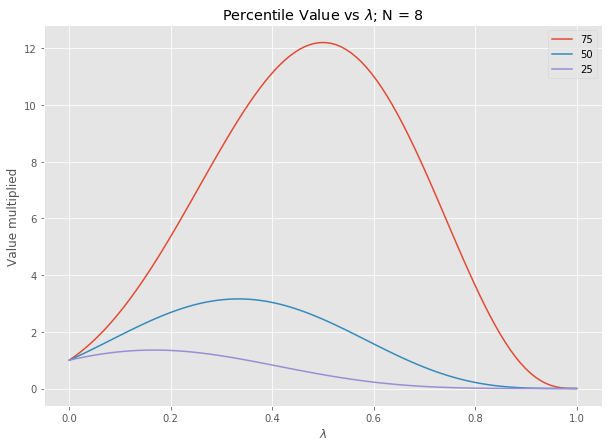

In [7]:
# just plot percentiles
NUM_TOSS = 8

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
percentiles = [25, 50, 75]

lams, datum = analyse(NUM_TOSS, Nlams=100, percentiles=percentiles)
plt.figure(figsize=(10,7))
for column in reversed(range(1, len(datum[0]))):
    plt.plot(lams, datum[:, column], label=str(percentiles[column-1]))
plt.title("Percentile Value vs $\lambda$; N = {}".format(NUM_TOSS))
plt.ylabel("Value multiplied")
plt.xlabel("$\lambda$")
plt.legend()
    


Text(0.5,0,'$\\lambda$')

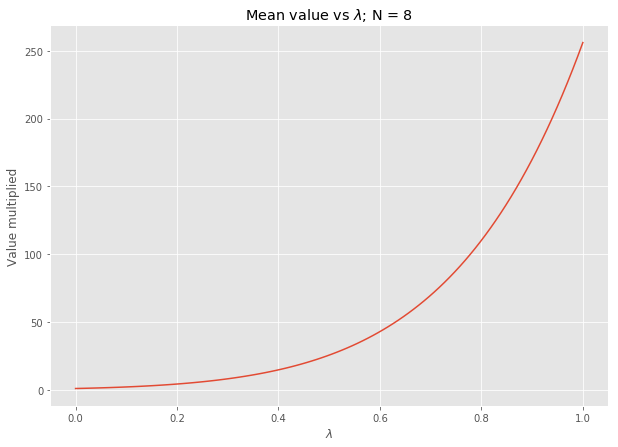

In [10]:
# means on a separate plot since these are much greater and the 0 values don't play nice with logs
plt.figure(figsize=(10,7))
plt.plot(lams, datum[:,0])
plt.title("Mean value vs $\lambda$; N = {}".format(NUM_TOSS))
plt.ylabel("Value multiplied")
plt.xlabel("$\lambda$")

In [91]:
print("peaks; N = {}".format(NUM_TOSS))
percentiles = ["mean", 25, 50, 75]
for cols in range(1, 4):
    ind = np.argmax(datum[:,cols])
    print(f"{percentiles[cols]}%, lambda={lams[ind]:.2f}:", end="")
    for col_p in range(4):
        print(f" {percentiles[col_p]}%={datum[:,col_p][ind]:.2f}", end = "")
    print()
# meanind = np.argmax(datum[:,0])
# print(f"mean, lambda={lams[meanind]:.2f}:", end="")
# for col_p in range(1,4):
#     print(f" {percentiles[col_p-1]}%={datum[:,col_p][ind]:.2f}", end = "")



peaks; N = 8
25%, lambda=0.17: mean%=3.55 25%=1.36 50%=2.48 75%=4.54
50%, lambda=0.33: mean%=9.99 25%=1.05 50%=3.16 75%=9.48
75%, lambda=0.49: mean%=24.95 25%=0.50 50%=2.48 75%=12.20


### Notes

A percentile level is not directly comparable in this setting and the percentile graph is best looked at as your range of return for a given $\lambda$. Optimizing for 75% results in your 25% case getting worse, while optimizing for your 25% case reduces your possible returns. The higher the percentile you'd like to optimize for, the higher lambda and vice versa and can be seen as a measure of risk taking. 

## Varied $\lambda$
So we can see that a fixed percentage playing mechanism barely taps into the possible value of the game at various percentile levels. Playing 33% of our value each time has a median value of 3.16 which feels surprisingly little given the high payout of the game. 

As brought up in the beginning, when I don't have many games left, I'd like to bet more aggressively, since my chances of missing out playing the game is much less and the chance of getting the 4x or 16x multiplier is high enough to be worth the risk. However, if I've already got a large amount earned, I might be less aggressive towards the end as I've already gained a lot of money. However, I'm not sure what the best way to code a strategy like this. Maybe a gratuitous amount of computing power can help work out the answer? See [part 2](/blog/reinforcement-tosser).